## Семинар 6 "Segmentation"

ФИО: Калашников Дмитрий Павлович

## Задание

Предлагается поучаствовать в конкурсе https://drive.grand-challenge.org/

Для зачета требуется получить значение dice-coefficient на leaderboard не меньше 0.8 и прислать ноутбук с кодом и кратким отчетом: что пробовали, что сделали, мысли почему окончательная архитектура лучше остальных.

Называйте своего юзера с суффиксом [sphere].

Также первые 3 человека получат бонусные 6, 4, 2 балл соответственно. (deadline: 23:59 14 апреля 2019). Скорее всего будут дополнительные плюшки для призеров конкурса.


In [212]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
import copy

import torch as t
from torch.utils import data
from torchvision import transforms as tsf
import scipy.misc

from pathlib import Path

from PIL import Image
import skimage
from skimage import io


TRAIN_PATH = './train.pth'
TEST_PATH = './test.pth'
%matplotlib inline

## Извлекаем данные

In [213]:
def process(dataset_path, mask_path=None):
    data = []
    if mask_path:
        mask_path = Path(mask_path)

    for image in sorted(Path(dataset_path).iterdir()):
        item = {}
        img = io.imread(image)
        
        if img.shape[2]>3:
            assert(img[:,:,3]!=255).sum()==0
        
        img = img[:,:,:3]
        item['name'] = image.name.split("_")[0]
        item['img'] = t.from_numpy(img)
        if mask_path:
            mask = io.imread(mask_path/(item['name'] + "_manual1.gif"))
            item['mask'] = t.from_numpy(mask)
        data.append(item)
    
    return data

test = process('test/images/')
t.save(test, TEST_PATH)
train_data = process('train/images', "train/1st_manual/")

## Готовим DataLoader-ы 

In [219]:
import PIL

class Dataset():
    def __init__(self, data, source_transform, target_transform):
        self.datas = data
        self.s_transform = source_transform
        self.t_transform = target_transform
        
    def __getitem__(self, index):
        data = self.datas[index]
        img = data['img'].numpy()
        mask = data['mask'][:,:,None].byte().numpy()
        img = self.s_transform(img)
        mask = self.t_transform(mask)
        
        return img, mask
    
    def __len__(self):
        return len(self.datas)

s_trans = tsf.Compose([
    tsf.ToPILImage(),
    tsf.Resize((256, 256)), # 128
    tsf.ToTensor(),
    tsf.Normalize(mean =[-0.00514589, -0.45865306, -0.67508024], std = [0.6946952 , 0.37769508, 0.21366659])
])

t_trans = tsf.Compose([
    tsf.ToPILImage(),
    tsf.Resize((256, 256), interpolation=PIL.Image.NEAREST), # 128
    tsf.ToTensor(),
    #tsf.Normalize(mean = [0.08609094], std = [0.28049827])
])

In [220]:
train_dataset = Dataset(train_data, s_trans, t_trans)

In [221]:
# def get_stat():
#     images = []
#     for inputs, labels in dataloader:
#         images.append(inputs.numpy())
#     images = np.concatenate(images, axis=0)
#     return images.mean(axis=(0, 2, 3)), images.std(axis=(0, 2, 3))

# res = [] 
# for _, mask in train_set:
#     res.append(mask.numpy())
# np.mean(res), np.std(res)

In [222]:
train_set, val_set = t.utils.data.random_split(train_dataset, [TRAIN_SIZE, VAL_SIZE])
train_dataloader = t.utils.data.DataLoader(train_set, batch_size=2)
val_dataloader = t.utils.data.DataLoader(val_set, batch_size=2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


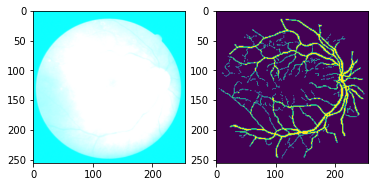

In [223]:
img, mask = val_set[0]
plt.subplot(121)
plt.imshow(img.permute(1,2,0))

plt.subplot(122)
plt.imshow(mask.permute(1,2,0))

## Custom Unet

In [6]:
# sub-parts of the U-Net model

from torch import nn
import torch.nn.functional as F

class double_conv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.conv(x)
        return x


class inconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(inconv, self).__init__()
        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x):
        x = self.conv(x)
        return x


class down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(down, self).__init__()
        self.mpconv = nn.Sequential(
            nn.MaxPool2d(2),
            double_conv(in_ch, out_ch)
        )

    def forward(self, x):
        x = self.mpconv(x)
        return x


class up(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=False):
        super(up, self).__init__()

        #  would be a nice idea if the upsampling could be learned too,
        #  but my machine do not have enough memory to handle all those weights
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_ch//2, in_ch//2, 2, stride=2)

        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, (diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2))
        
        # for padding issues, see 
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd

        x = t.cat([x2, x1], dim=1)
        x = self.conv(x)
        return x


class outconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(outconv, self).__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, 1)

    def forward(self, x):
        x = self.conv(x)
        return x


class UNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        self.inc = inconv(n_channels, 64)
        self.down1 = down(64, 128)
        self.down2 = down(128, 256)
        self.down3 = down(256, 512)
        self.down4 = down(512, 1024)
        self.up1 = up(1024, 256)
        self.up2 = up(512, 128)
        self.up3 = up(256, 64)
        self.up4 = up(128, 64)
        self.outc = outconv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.outc(x)
        x = t.nn.functional.sigmoid(x)
        return x

## Dice Loss

In [224]:
# Попробуйте использовать различные функции потерь.
def soft_dice_loss(inputs, targets):
    num = targets.size(0)
    m1  = inputs.view(num,-1)
    m2  = targets.view(num,-1)
    intersection = (m1 * m2)
    score = 2. * (intersection.sum(1) + 1) / (m1.sum(1) + m2.sum(1) + 1)
    score = 1 - score.sum() / num
    #score = score.sum() / num
    
    return score

## Train

In [225]:
device = t.device("cuda:0" if t.cuda.is_available() else "cpu")

In [226]:
TRAIN_SIZE = 18
VAL_SIZE = 2
IMAGE_SIZE = 256

dataset_sizes = {
    'train' : TRAIN_SIZE,
    'val' : VAL_SIZE
}

In [227]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        train_set, val_set = t.utils.data.random_split(train_dataset, [TRAIN_SIZE, VAL_SIZE])
        train_dataloader = t.utils.data.DataLoader(train_set, batch_size=2)
        val_dataloader = t.utils.data.DataLoader(val_set, batch_size=2)

        dataloaders = {
            'train' : train_dataloader,
            'val' : val_dataloader
        }

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with t.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    #print('output:',outputs.shape)
                    #print('max:', t.max(outputs, dim=1).shape)
                    preds = outputs
                    #_, preds = t.max(outputs, dim=1) # TODO
                    
                    #print('pred:', _.shape)
                    #print('pred:', preds.shape)
                    
                    
                    #print('input shape:', inputs.shape)
                    #print('output shape:', outputs.shape)
                    #print('label shape:', labels.shape)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                #print(phase)
                #print('input shape', inputs.shape)
                #print('input size[0]:', inputs.size(0))
                #inputs.size(0)
                #print('preds shape', preds.shape)
                #print('labels shape', labels.shape)
                running_loss += loss.item() * inputs.size(0) 
                running_corrects += t.sum(preds == labels.data)
                
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / (dataset_sizes[phase] * IMAGE_SIZE * IMAGE_SIZE)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [228]:
model = t.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',
        in_channels=3, out_channels=1, init_features=32, pretrained=True)

#model = model.to(device)

Using cache found in /Users/Dmitry/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master


In [173]:
criterion = soft_dice_loss # nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = t.optim.Adam(model.parameters(), lr=0.0001) # 0.001 # , momentum=0.9

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = t.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

model = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=5) # 25

# fine-tuning https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

Epoch 0/4
----------
train Loss: 0.8141 Acc: 0.0005
val Loss: 0.7984 Acc: 0.0005

Epoch 1/4
----------
train Loss: 0.6965 Acc: 0.0028
val Loss: 0.6966 Acc: 0.0027

Epoch 2/4
----------
train Loss: 0.6128 Acc: 0.0061
val Loss: 0.5382 Acc: 0.0107

Epoch 3/4
----------
train Loss: 0.5552 Acc: 0.0115
val Loss: 0.6617 Acc: 0.0132

Epoch 4/4
----------
train Loss: 0.5144 Acc: 0.0122
val Loss: 0.5894 Acc: 0.0191

Training complete in 3m 28s
Best val Acc: 0.019135


## Predict

In [12]:
class TestDataset():
    def __init__(self,path, source_transform):
        self.datas = t.load(path)
        self.s_transform = source_transform
        
    def __getitem__(self, index):
        data = self.datas[index]
        img = data['img'].numpy()
        img = self.s_transform(img)
        return img
    
    def __len__(self):
        return len(self.datas)

testset = TestDataset(TEST_PATH, s_trans)
testdataloader = t.utils.data.DataLoader(testset,batch_size=1)

In [13]:
os.makedirs("result")
!zip -r result.zip result

  adding: result/ (stored 0%)


In [15]:
model = model.eval()

for ex_id, data in enumerate(testdataloader):
    data = t.autograd.Variable(data, volatile=True).cpu()
    o = model(data)
    
    source_image = io.imread("test/images/%s_test.tif" % str(ex_id + 1).zfill(2))
    tm = o[0][0].data.cpu().numpy() # TODO: точно ли первый индекс 0, а не порядковый
    tm = skimage.transform.resize(tm, source_image.shape[:-1])
    tm = (tm > 0.5).astype(int)
    
    scipy.misc.imsave("test/result/%s.png" % (ex_id + 1), tm)

<ipython-input-15-cf4c2295e159>:4: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = t.autograd.Variable(data, volatile=True).cpu()


RuntimeError: Given transposed=1, weight of size [512, 512, 2, 2], expected input[1, 1024, 8, 8] to have 512 channels, but got 1024 channels instead

In [76]:
tm = o[0][0].data.cpu().numpy()
plt.subplot(121)
plt.imshow(data[0].data.cpu().permute(1,2,0).numpy()*0.5+0.5)
plt.subplot(122)
plt.imshow(tm)

## Проверка

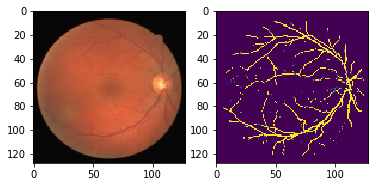

In [130]:
tm = o[0][0].data.cpu().numpy()
plt.subplot(121)
plt.imshow(data[0].data.cpu().permute(1,2,0).numpy()*0.5+0.5)
plt.subplot(122)
plt.imshow(tm)